# Clustering using Hidden Markov Model 

### Import packages

In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from hmmlearn import hmm
from simpl_eeg import (
    connectivity,
    eeg_objects,
    raw_voltage,
    topomap_2d,
    topomap_3d_brain,
    topomap_3d_head,
)

### Plotting function

In [2]:
# Adapted from MDS 563 lecture 2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def plot_pca_clusters(data, labels):
    """
    Carries out dimensionality reduction on the data for visualization
    """
    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(
        data=principal_comp, columns=["pca1", "pca2"], index=data.index
    )
    pca_df["cluster"] = labels
    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10"
    )
    plt.show()

### Read in the data

In [3]:
raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")

Reading C:\Users\Yiki\Documents\UBC\MDS\Homework\capstone\simpl_eeg_capstone\data\927\fixica.fdt


<ipython-input-3-99b5e4cf8c83>:1: RuntimeWarning: Data file name in EEG.data (927 fix ica correct.fdt) is incorrect, the file name must have changed on disk, using the correct file name (fixica.fdt).
  raw_full = mne.io.read_raw_eeglab("../../data/927/fixica.set")


In [4]:
entire_df = raw_full.to_data_frame()

### Data preprocessing

In [5]:
# to get average chunked data

cleaned_df = entire_df[(entire_df.T != 0).any()]  # drop rows where all values are zero

sliced_df = entire_df.iloc[:5540000]
avg_chunked_list = []
for i in range(554):
    avg_sliced_array = (
        sliced_df.iloc[i * 10000 : i * 10000 + 10000, 1:].mean().to_numpy()
    )  # separate the data into chunks of per 5 seconds and get the average
    avg_chunked_list.append(avg_sliced_array)
avg_chunked_array = np.array(avg_chunked_list)

In [6]:
# to get chunk data, not used since file is too large and the operation runs out of memory

# avg_df = entire_df.groupby("time").mean().reset_index()
# entire_list = []
# for i in range(541):
#     sliced_array = avg_df.iloc[i*10000:i*10000+10000, 1:].to_numpy().reshape(-1)
#     entire_list.append(sliced_array)
# entire_array_chunk = np.array(entire_list)

# entire_array_chunk=np.float32(entire_array_chunk)

### Hyperparameter tuning

In [7]:
tune_comp = {}
model_list = []
for n_comp in range(5, 21, 1):
    model = hmm.GaussianHMM(n_components=n_comp)
    model_list.append(model)
    model.fit(avg_chunked_array)
    result = model.decode(avg_chunked_array, algorithm="viterbi")
    tune_comp[n_comp] = result[0]

In [8]:
maximum = max(tune_comp, key=tune_comp.get)
print(
    f"The best # of cluster is {maximum}, with log probability of {tune_comp[maximum]}"
)

The best # of cluster is 20, with log probability of -1518.512035638551


### Model fitting

In [9]:
model19 = model_list[14]
model19

GaussianHMM(n_components=19)

In [10]:
result19 = model19.decode(avg_chunked_array, algorithm="viterbi")

In [11]:
result_df19 = sliced_df.copy()
for index, labels in enumerate(result19[1]):
    result_df19.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

In [12]:
model20 = model_list[-1]
model20

GaussianHMM(n_components=20)

In [13]:
result20 = model20.decode(avg_chunked_array, algorithm="viterbi")

In [14]:
result_df20 = sliced_df.copy()
for index, labels in enumerate(result20[1]):
    result_df20.loc[index * 10000 : index * 10000 + 10000, "cluster"] = labels

### PCA 

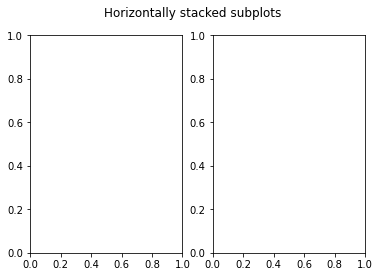

C:\Users\Yiki\miniconda3\envs\capstone\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


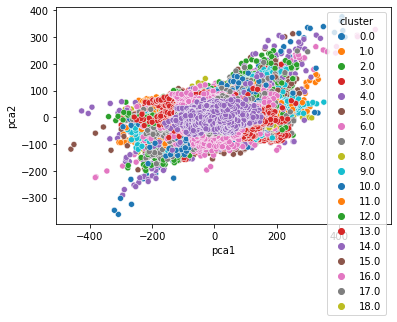

C:\Users\Yiki\miniconda3\envs\capstone\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


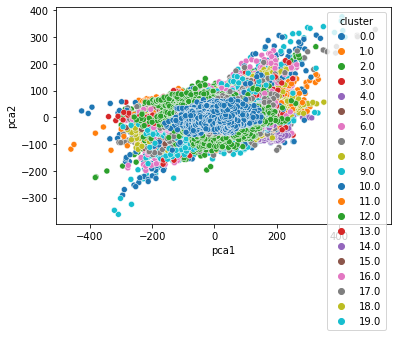

In [15]:
pca19=plot_pca_clusters(result_df19.iloc[:, 1:20], result_df19.cluster)
pca20=plot_pca_clusters(result_df20.iloc[:, 1:20], result_df20.cluster)

### Correlation

In [19]:
df_corr19 = {}
for i in range(19):
    df_corr19[i] = result_df19[result_df19['cluster'] == i].iloc[:, 1:20].corr()

In [31]:
df_corr20 = {}
for i in range(20):
    df_corr20[i] = result_df20[result_df20['cluster'] == i].iloc[:, 1:20].corr()

<ipython-input-28-b104cac98023>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


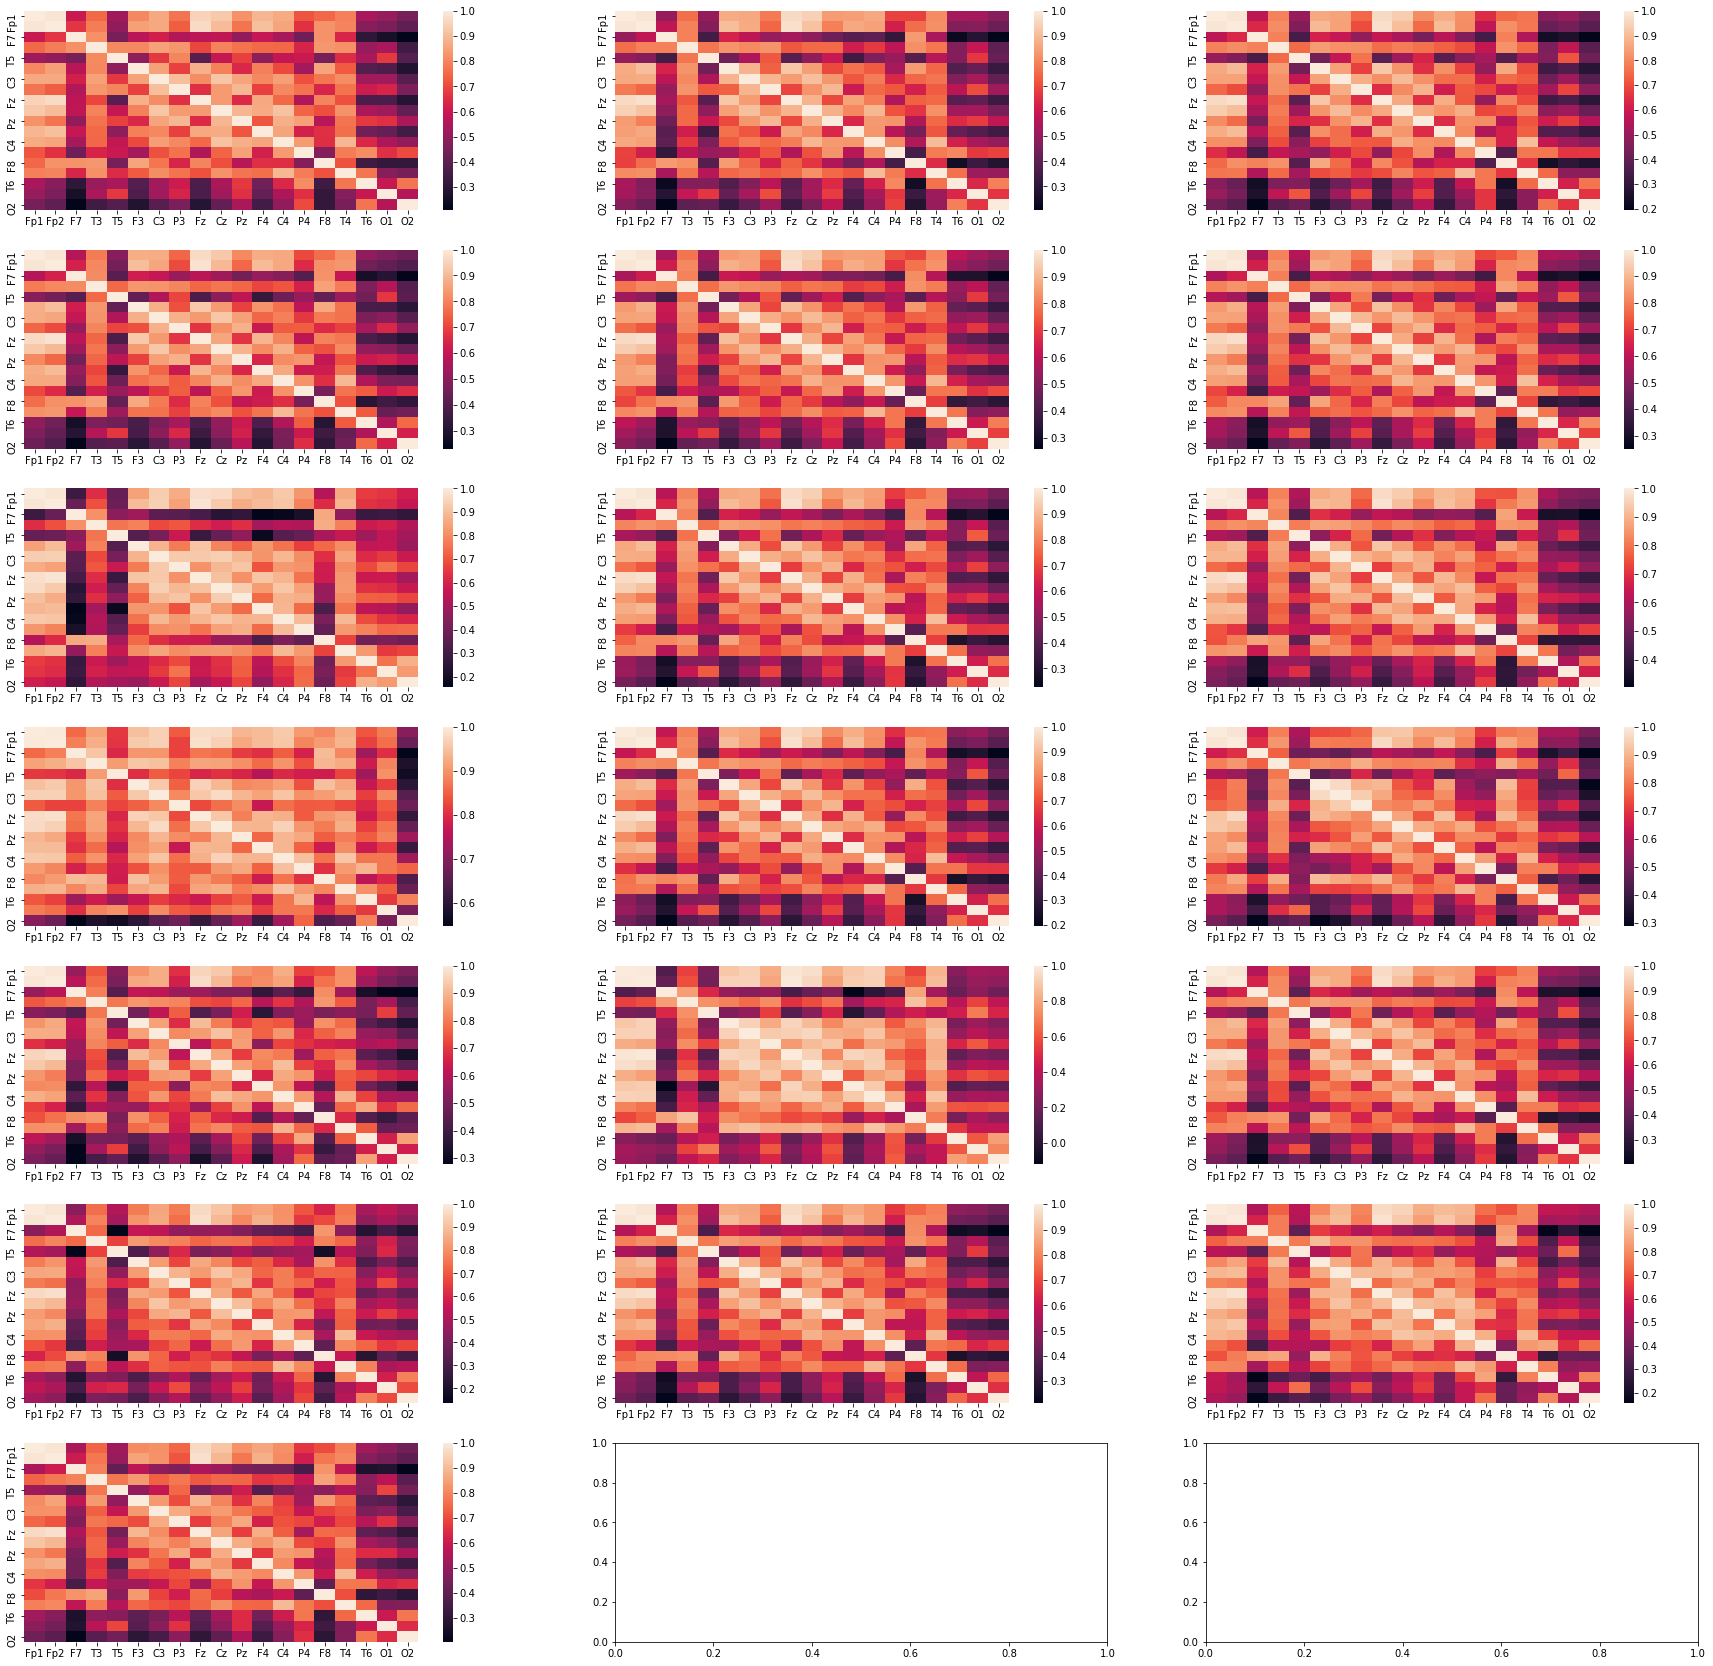

In [28]:
# Set figsize here
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(30, 30))

for i, ax in enumerate(axes.flatten()[:19]):
    sns.heatmap(df_corr19[i], ax=ax)

fig.show()

<ipython-input-32-b712e4c9140f>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


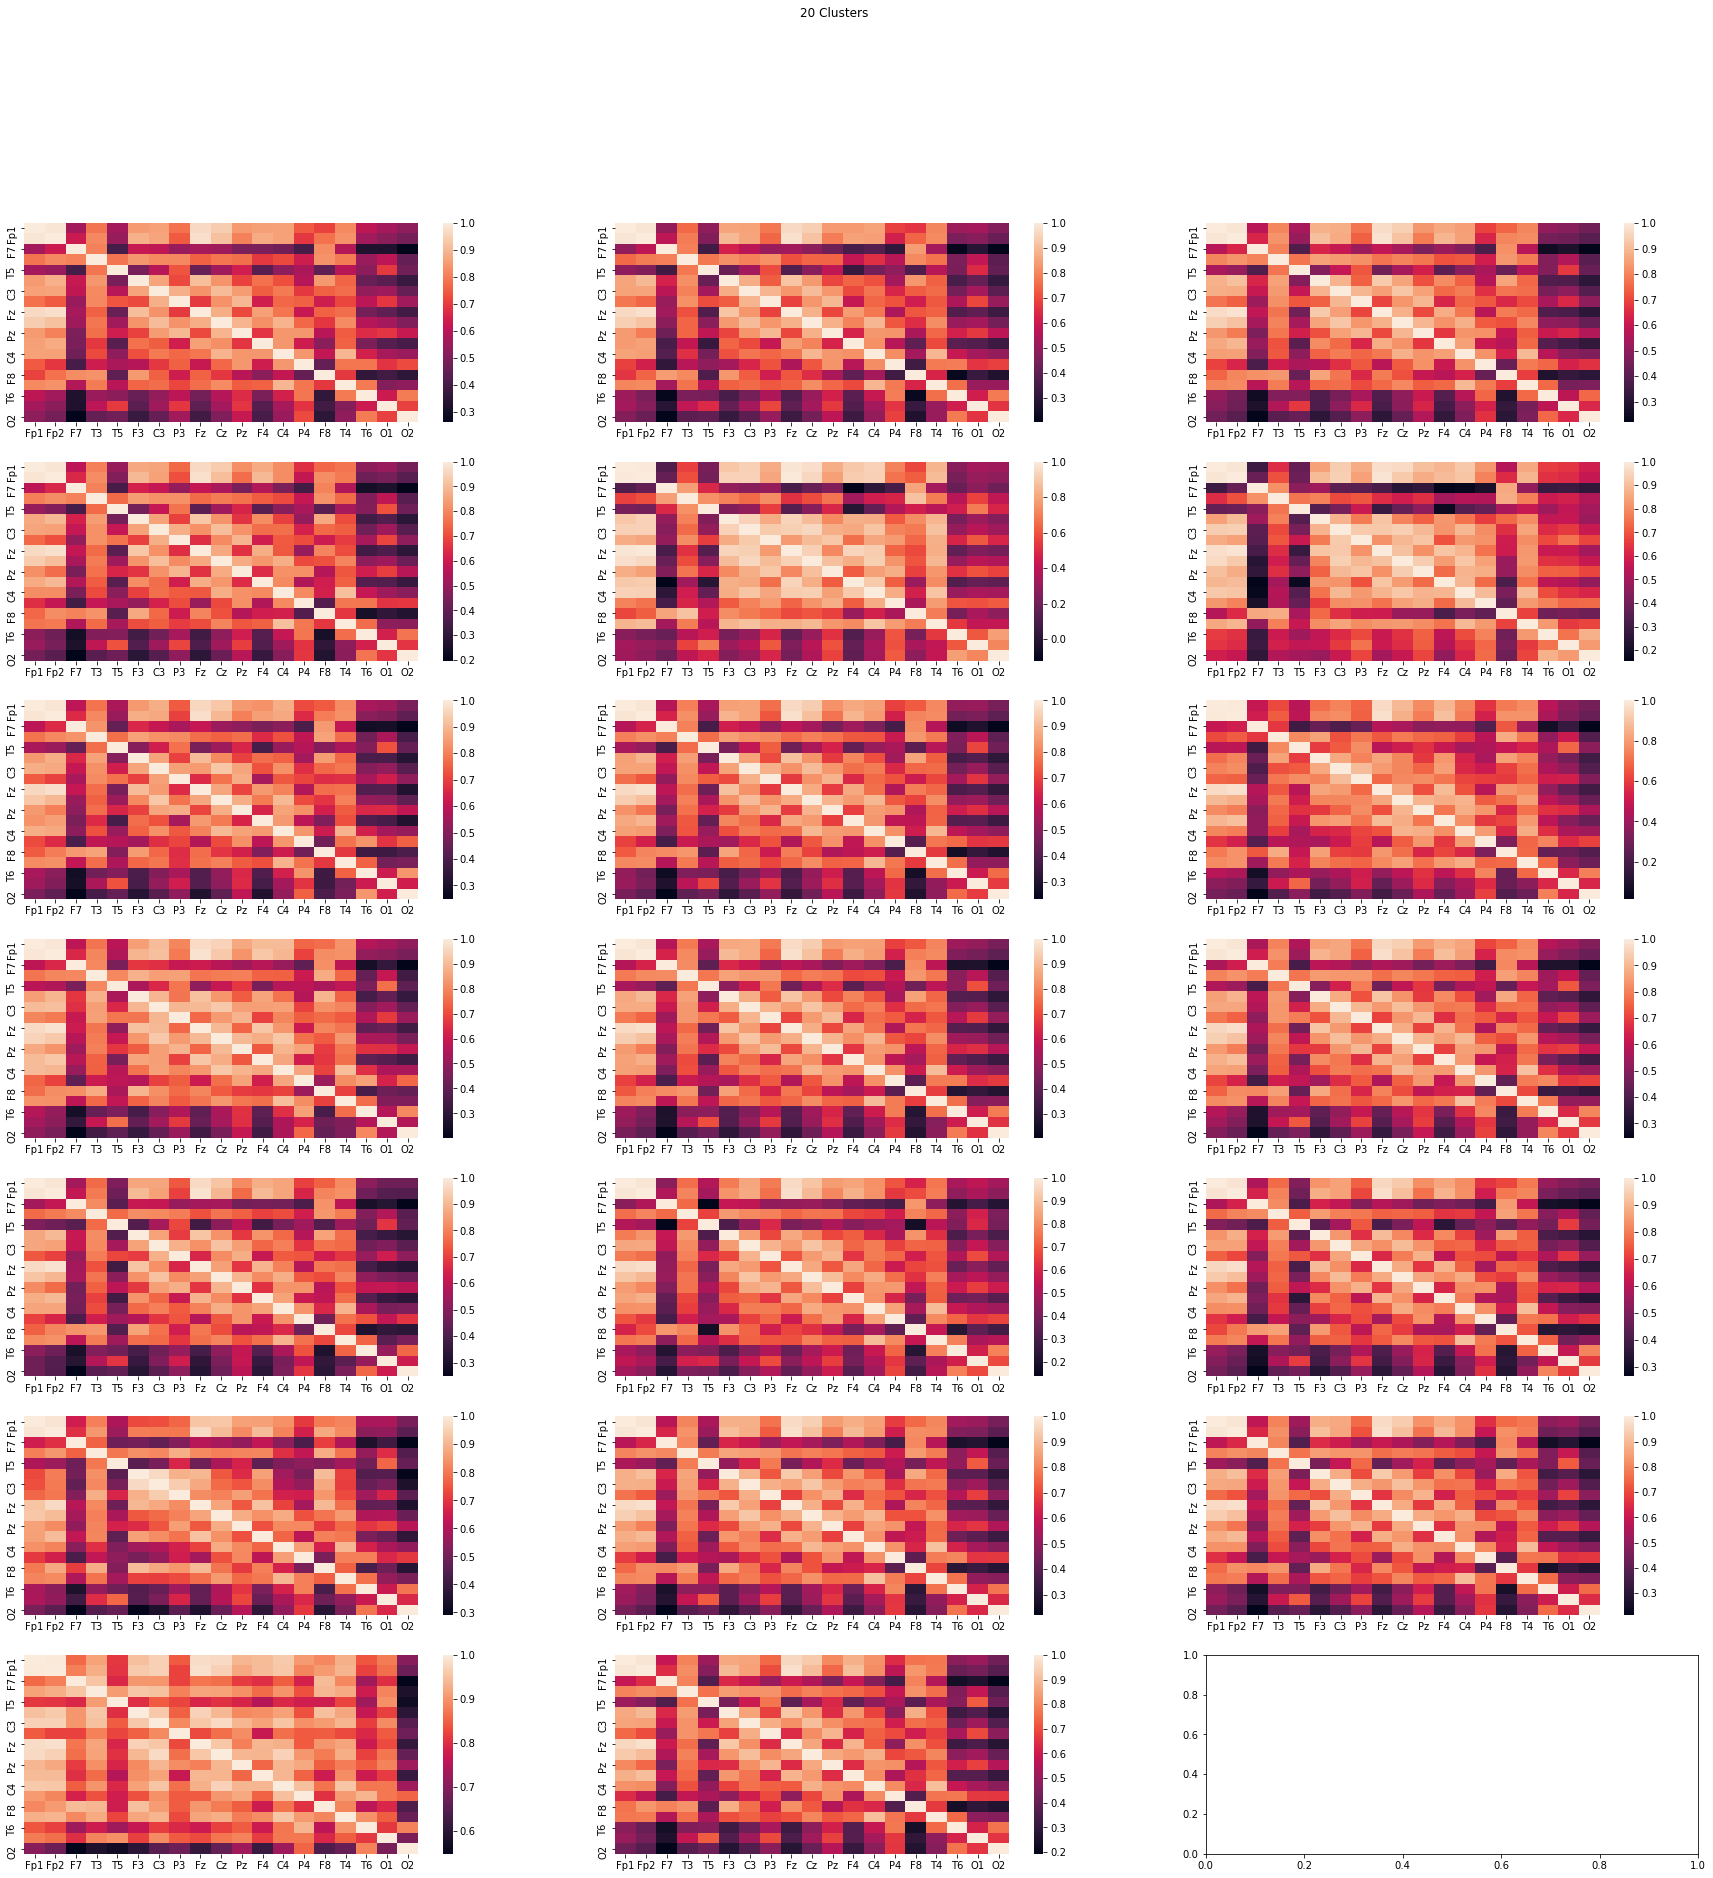

In [32]:
fig1, axes1 = plt.subplots(nrows=7, ncols=3, figsize=(30, 30))
fig1.suptitle('20 Clusters')

for i, ax in enumerate(axes1.flatten()[:20]):
    sns.heatmap(df_corr20[i], ax=ax)

fig1.show()

### Violin plot

In [33]:
df_sub19 = {}
for i in range(19):
    df_sub19[i] = result_df19[result_df19['cluster'] == i].iloc[:, 1:20]

In [35]:
df_sub20 = {}
for i in range(20):
    df_sub20[i] = result_df20[result_df20['cluster'] == i].iloc[:, 1:20]

In [42]:
%matplotlib inline

<ipython-input-43-5f059ca55641>:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


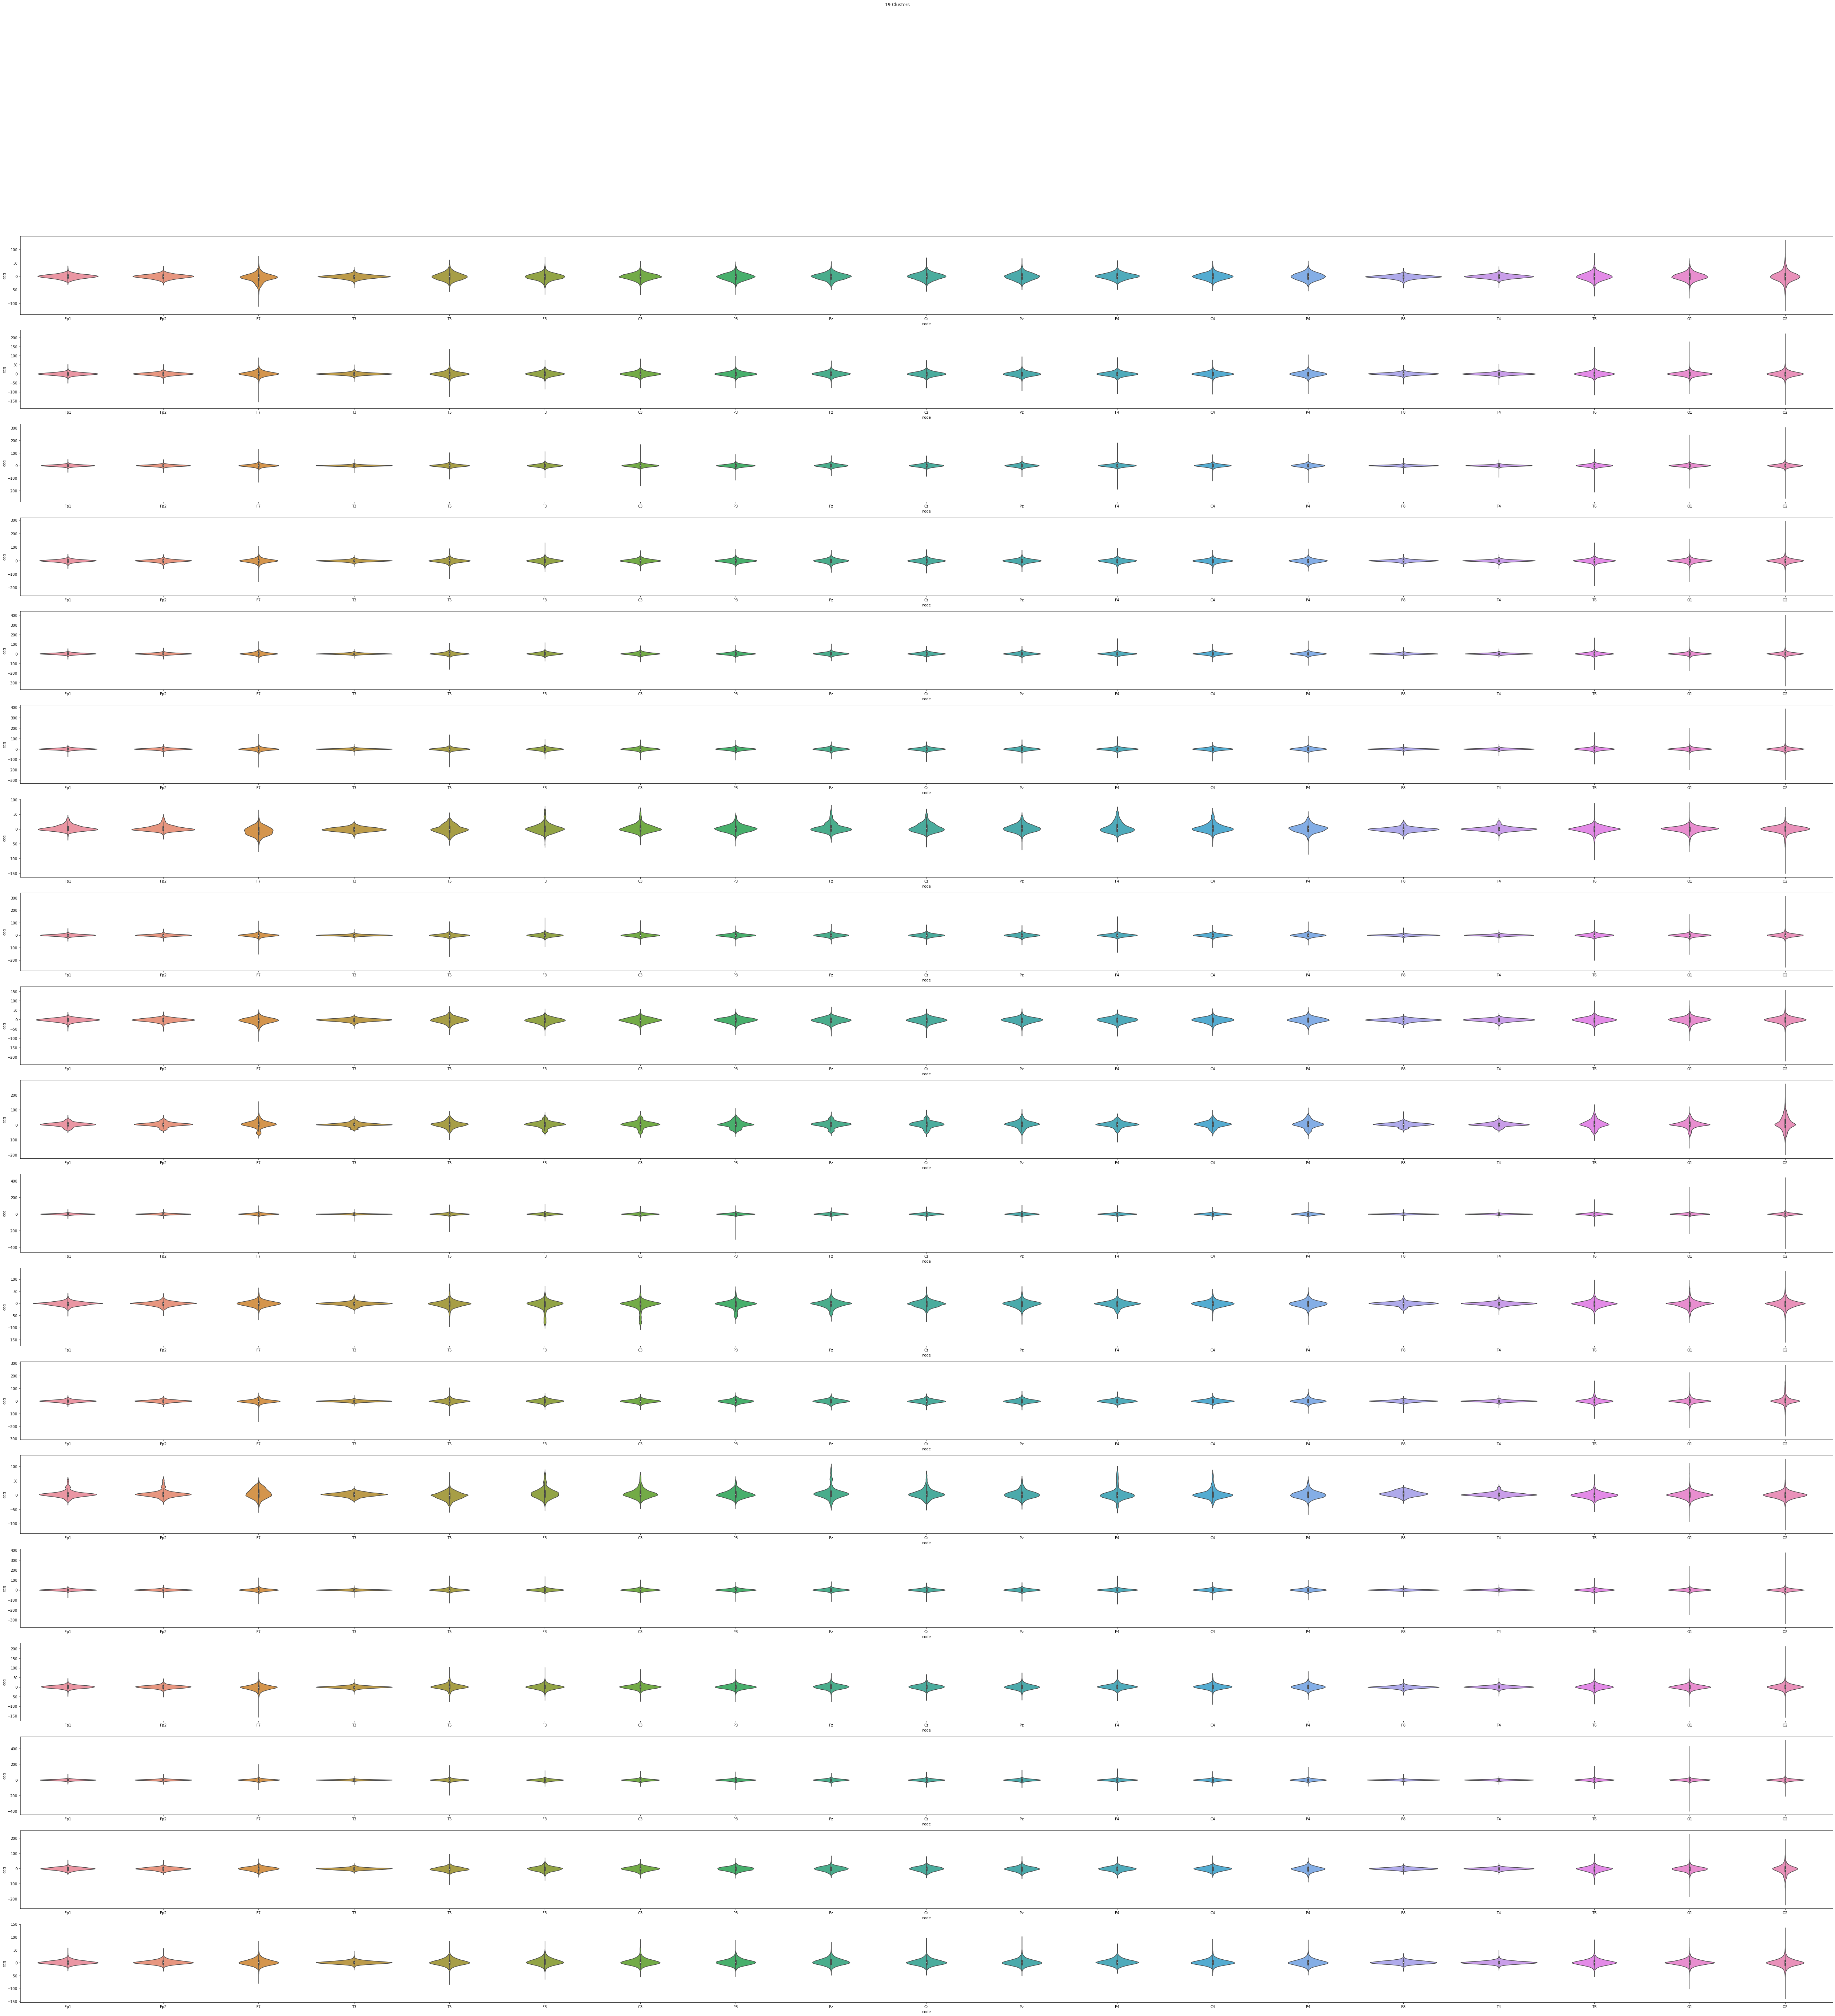

In [43]:
fig2, axes2 = plt.subplots(nrows=19, ncols=1, figsize=(90, 90))
fig2.suptitle('19 Clusters')

for i, ax in enumerate(axes2.flatten()[:19]):
    sns.violinplot(x="node", y="eeg", data=df_sub19[i].melt(var_name="node", value_name="eeg"), ax=ax)

fig2.show()

<ipython-input-44-812056a6ec3f>:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


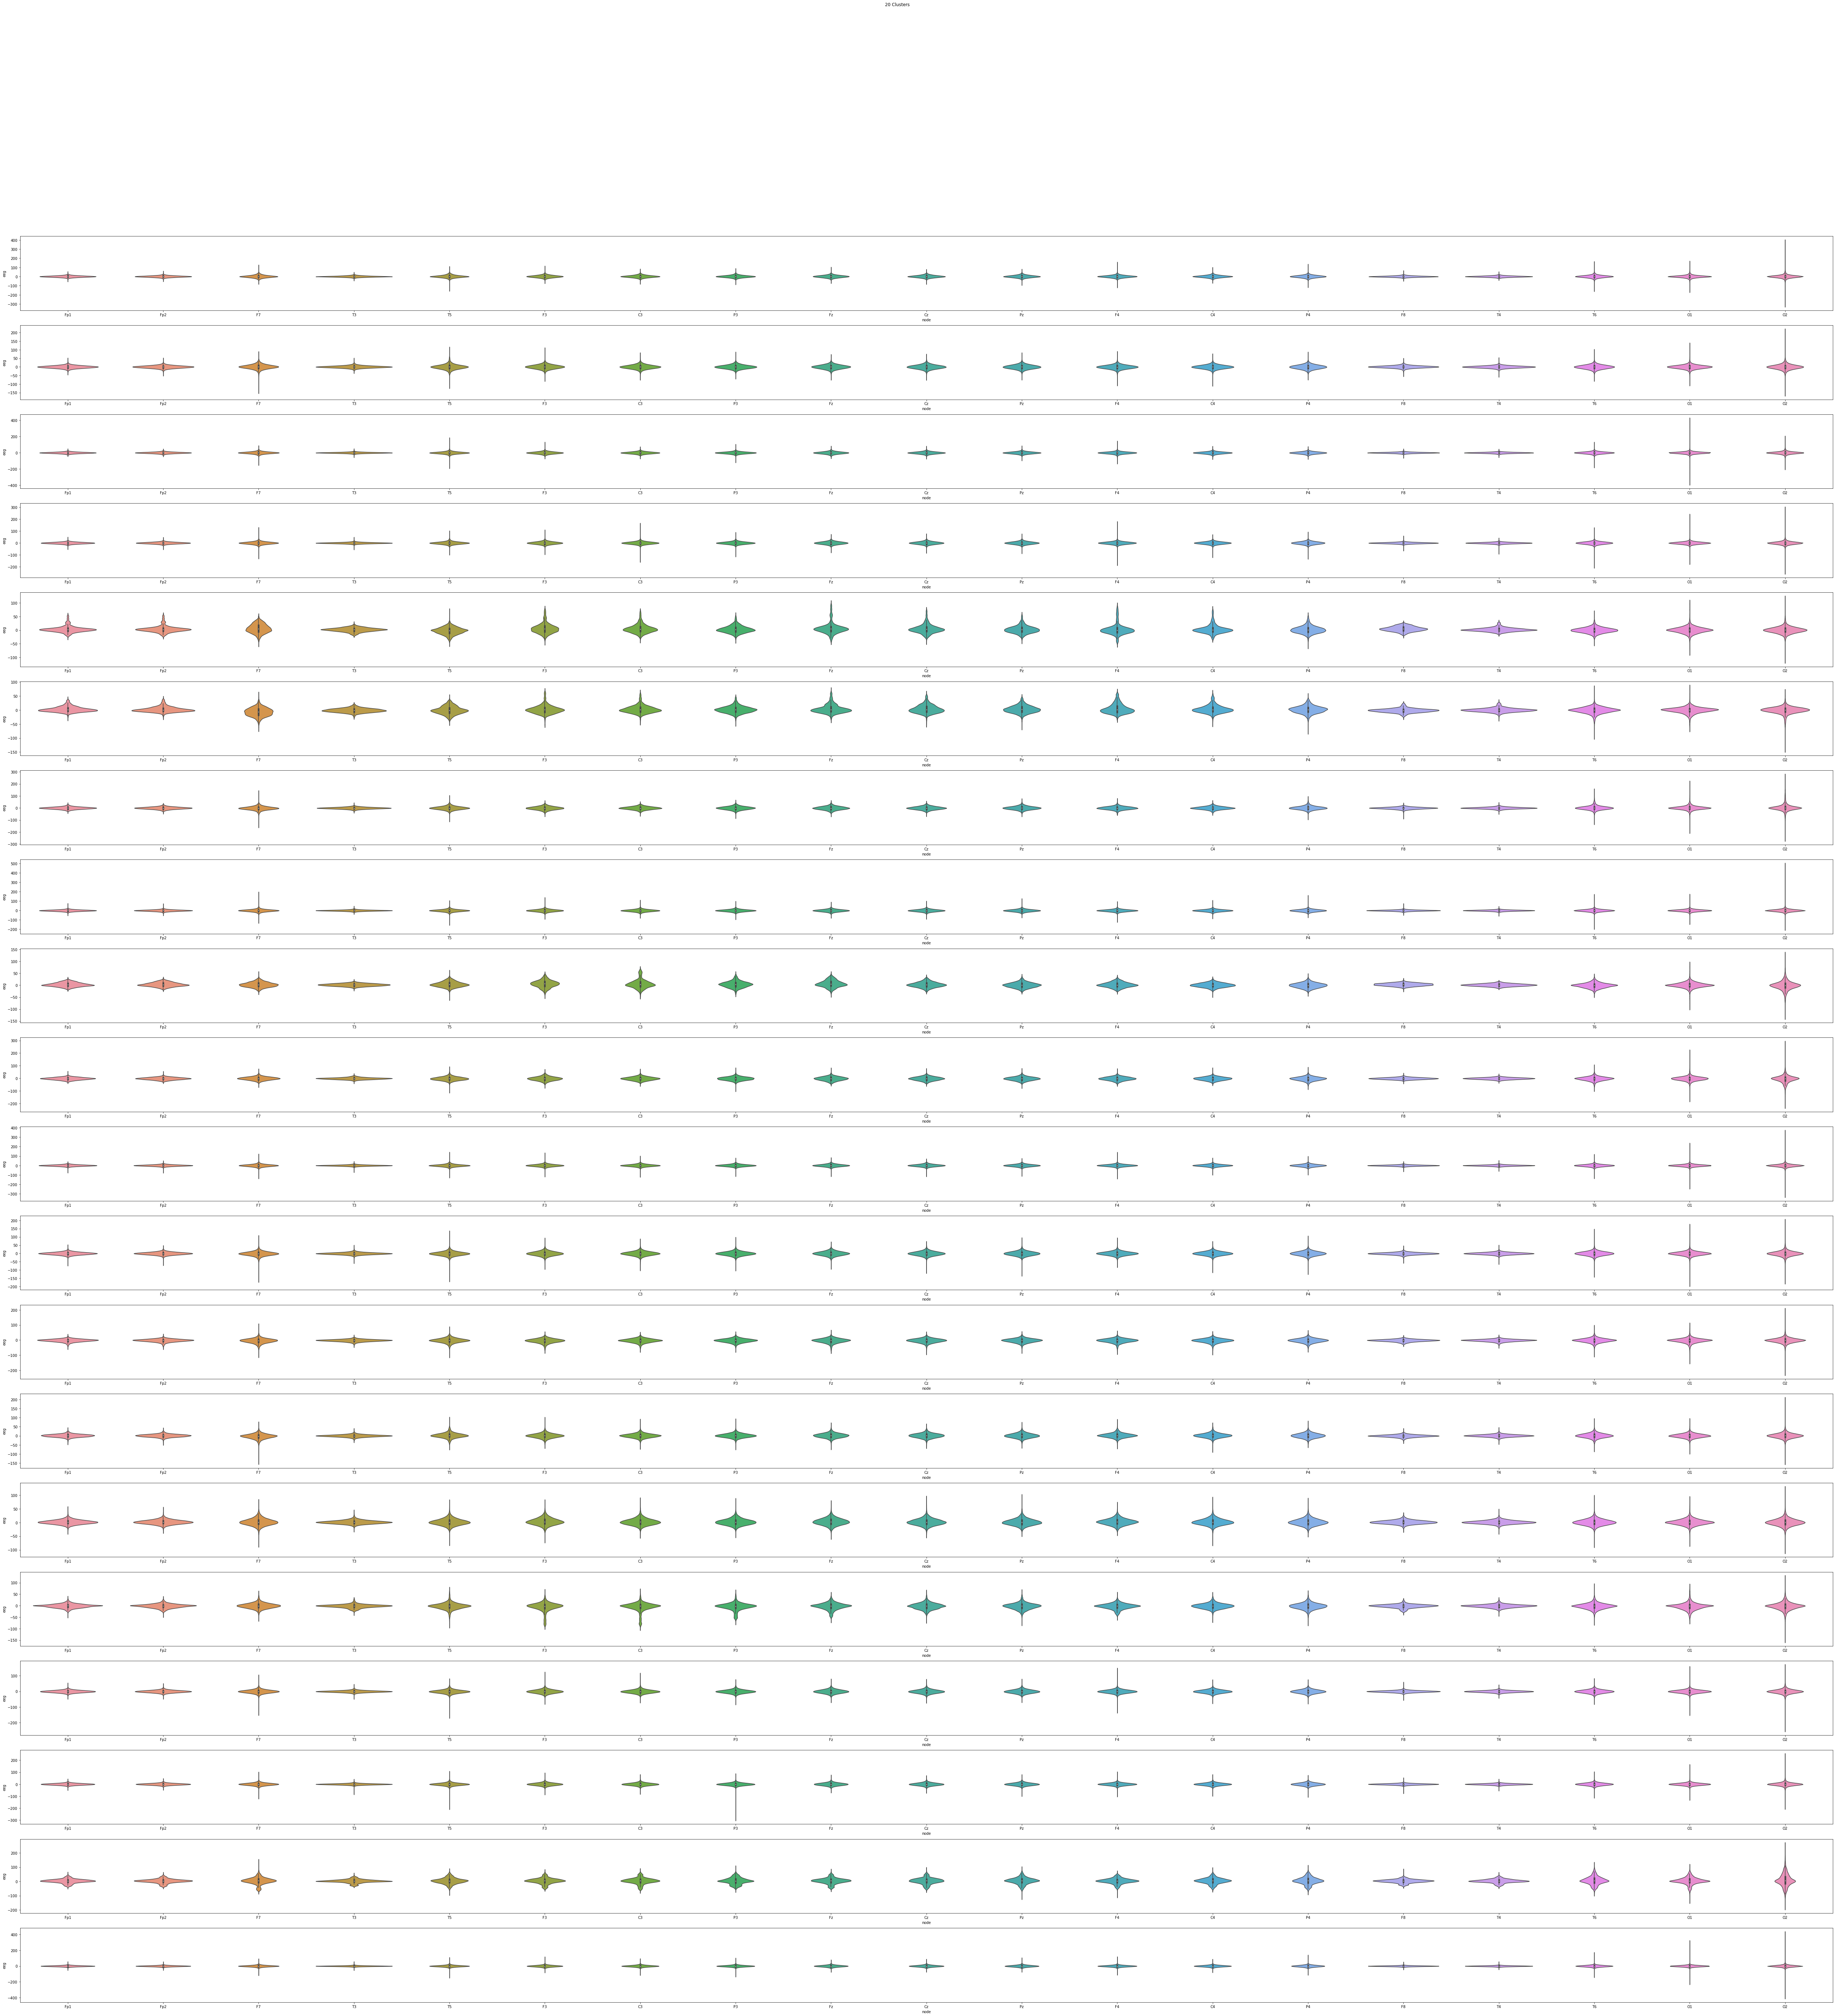

In [44]:
fig3, axes3 = plt.subplots(nrows=20, ncols=1, figsize=(90, 90))
fig3.suptitle('20 Clusters')

for i, ax in enumerate(axes3.flatten()[:20]):
    sns.violinplot(x="node", y="eeg", data=df_sub20[i].melt(var_name="node", value_name="eeg"), ax=ax)

fig2.show()